# Modélisation supervisée

### Import des modules 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor


### Importation des données  
Chargement du fichier CSV pour préparer le dataset.

In [2]:
ml_df = pd.read_csv('ML_modele.csv')

### Aperçu du dataset  
Visualisation des premières lignes pour vérifier la structure.

In [3]:
ml_df.head()

,BuildingAge,Surface moyenne par étage,Ratio Largest Use / Total,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,PropertyCategory,SiteEnergyUse(kBtu),PropertyCategory_Healthcare,PropertyCategory_Hospitality,PropertyCategory_Industrial & Storage,PropertyCategory_Mixed Use,PropertyCategory_Office,PropertyCategory_Other,PropertyCategory_Public / Institutional,PropertyCategory_Retail & Food
0,89,7369.500000,1.000000,1.0,12,88434,0,88434,88434.0,0.0,Hospitality,7226362.5,0,1,0,0,0,0,0,0
1,20,9415.090909,0.809918,1.0,11,103566,15064,88502,83880.0,15064.0,Hospitality,8387933.0,0,1,0,0,0,0,0,0
2,47,23319.756098,0.791220,1.0,41,956110,196718,759392,756493.0,0.0,Hospitality,72587024.0,0,1,0,0,0,0,0,0
3,90,6132.000000,1.000000,1.0,10,61320,0,61320,61320.0,0.0,Hospitality,6794584.0,0,1,0,0,0,0,0,0
4,36,9754.444444,0.703070,1.0,18,175580,62000,113580,123445.0,68009.0,Hospitality,14172606.0,0,1,0,0,0,0,0,0


In [4]:
ml_df.shape

(1627, 20)

### Statistiques descriptives de la cible  
Résumé statistique pour identifier la distribution et les valeurs extrêmes.

In [5]:
# définir la cible (utile pour les cellules suivantes)
target = "SiteEnergyUse(kBtu)"

In [6]:
# Aperçu général de la variable cible
print("len(ml_df) =", len(ml_df))
print("Nombre de valeurs manquantes dans la cible:", ml_df[target].isna().sum())
print("la cible s'appelle:", target)
ml_df["SiteEnergyUse(kBtu)"].describe()

len(ml_df) = 1627
Nombre de valeurs manquantes dans la cible: 2
la cible s'appelle: SiteEnergyUse(kBtu)


count    1.625000e+03
mean     8.459831e+06
std      3.058993e+07
min      0.000000e+00
25%      1.215156e+06
50%      2.499140e+06
75%      6.858534e+06
max      8.739237e+08
Name: SiteEnergyUse(kBtu), dtype: float64

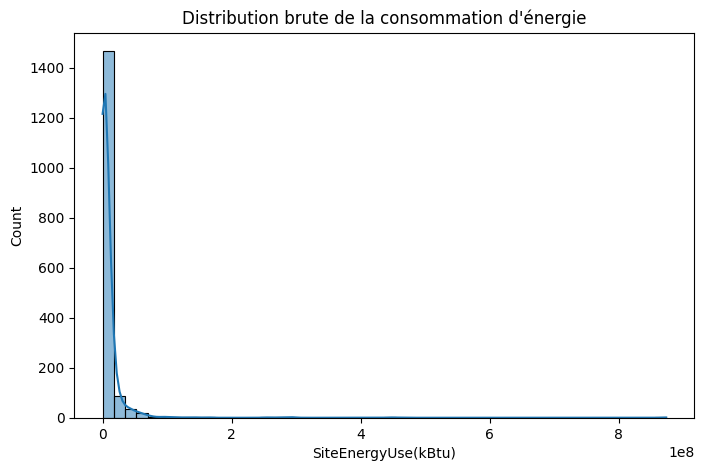

In [7]:
# Distribution brute de la consommation d'énergie
plt.figure(figsize=(8,5))
sns.histplot(ml_df["SiteEnergyUse(kBtu)"], bins=50, kde=True)
plt.title("Distribution brute de la consommation d'énergie")
plt.xlabel("SiteEnergyUse(kBtu)")
plt.show()

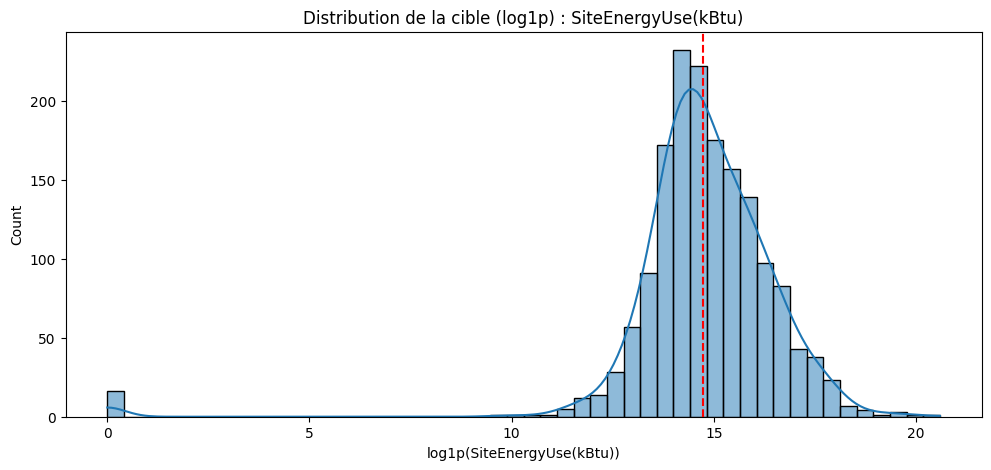

In [8]:
#distribution de la cible (log1p)
s = ml_df[target].dropna()
s_log = np.log1p(s)
pcts = {0.25: s_log.quantile(0.25), 0.5: s_log.quantile(0.5), 0.75: s_log.quantile(0.75), 0.9: s_log.quantile(0.9), 0.95: s_log.quantile(0.95)}
plt.figure(figsize=(26,5))
# Histogramme + KDE de la cible transformée (log1p)
plt.subplot(1,2,2)
sns.histplot(s_log, bins=50, kde=True)
plt.title(f"Distribution de la cible (log1p) : {target}")
plt.xlabel(f"log1p({target})")
plt.axvline(pcts[0.5], color='r', linestyle='--')
plt.show()


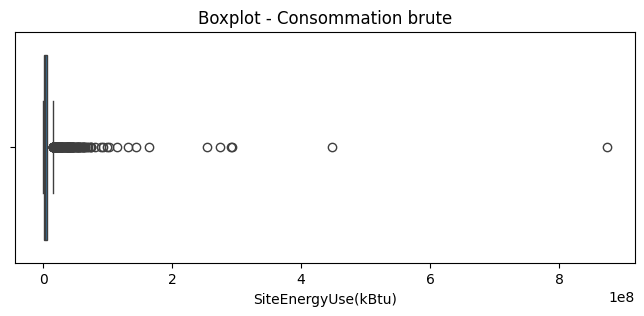

In [9]:
plt.figure(figsize=(8,3))
sns.boxplot(x=ml_df["SiteEnergyUse(kBtu)"])
plt.title("Boxplot - Consommation brute")
plt.show()

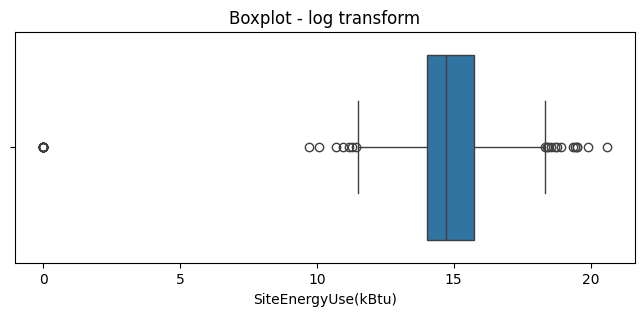

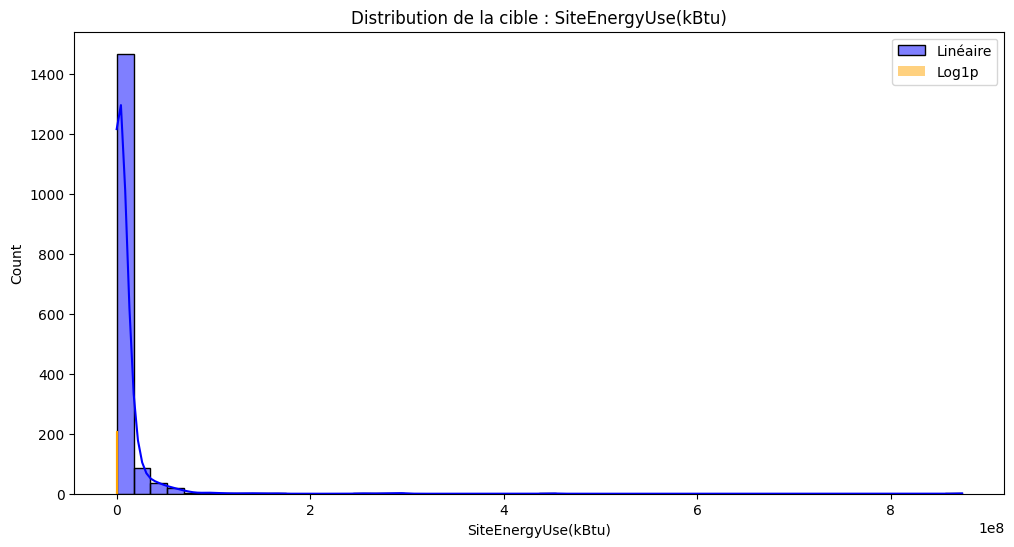

In [10]:
plt.figure(figsize=(8,3))
sns.boxplot(x=np.log1p(ml_df["SiteEnergyUse(kBtu)"]))
plt.title("Boxplot - log transform")
plt.show()
# Distribution de la cible (log1p vs linéaire)
s = ml_df[target].dropna()
s_log = np.log1p(s)
plt.figure(figsize=(12,6))
sns.histplot(s, bins=50, kde=True, color='blue', label='Linéaire')
sns.histplot(s_log, bins=50, kde=True, color='orange', label='Log1p')
plt.title(f"Distribution de la cible : {target}")
plt.xlabel(f"{target}")
plt.legend()
plt.show()

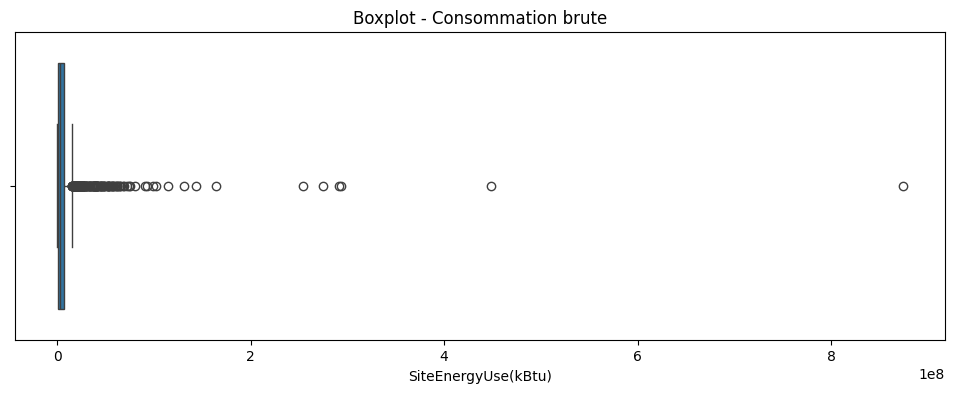

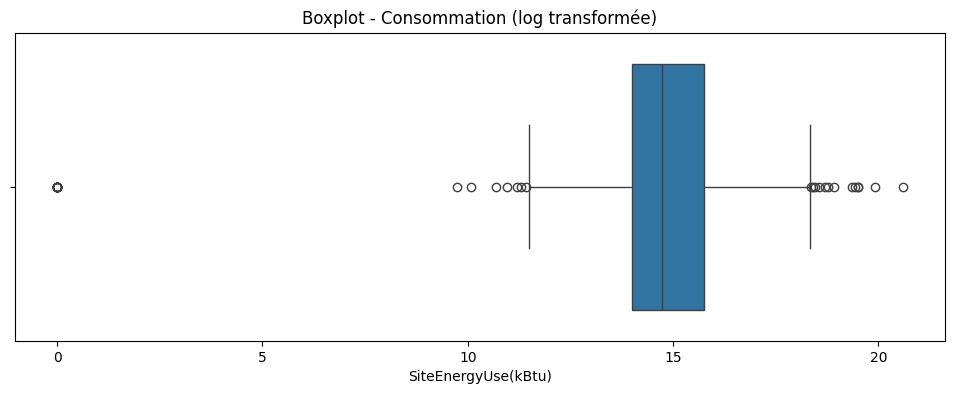

In [11]:
plt.figure(figsize=(12,4))
sns.boxplot(x=ml_df["SiteEnergyUse(kBtu)"])
plt.title("Boxplot - Consommation brute")
plt.show()

plt.figure(figsize=(12,4))
sns.boxplot(x=np.log1p(ml_df["SiteEnergyUse(kBtu)"]))
plt.title("Boxplot - Consommation (log transformée)")
plt.show()


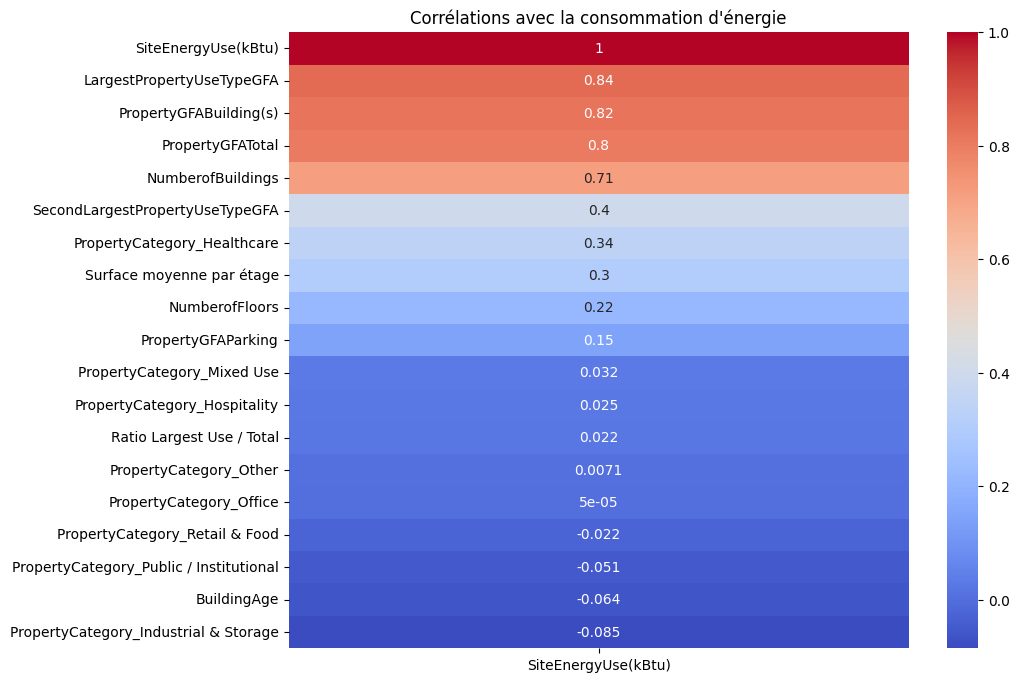

In [12]:
plt.figure(figsize=(10,8))
sns.heatmap(
    ml_df.corr(numeric_only=True)["SiteEnergyUse(kBtu)"].sort_values(ascending=False).to_frame(),
    annot=True, cmap="coolwarm", cbar=True
)
plt.title("Corrélations avec la consommation d'énergie")
plt.show()


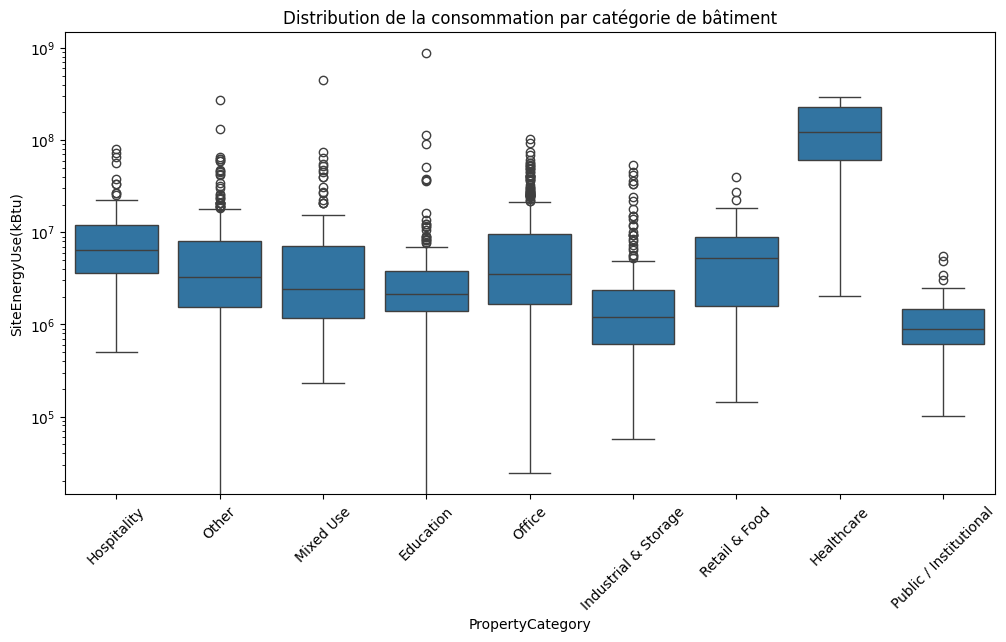

In [13]:
# Consommation par catégorie de bâtiment en boxplot     
plt.figure(figsize=(12,6))
sns.boxplot(x="PropertyCategory", y="SiteEnergyUse(kBtu)", data=ml_df)
plt.yscale("log")  # car les écarts sont énormes
plt.title("Distribution de la consommation par catégorie de bâtiment")
plt.xticks(rotation=45)
plt.show()

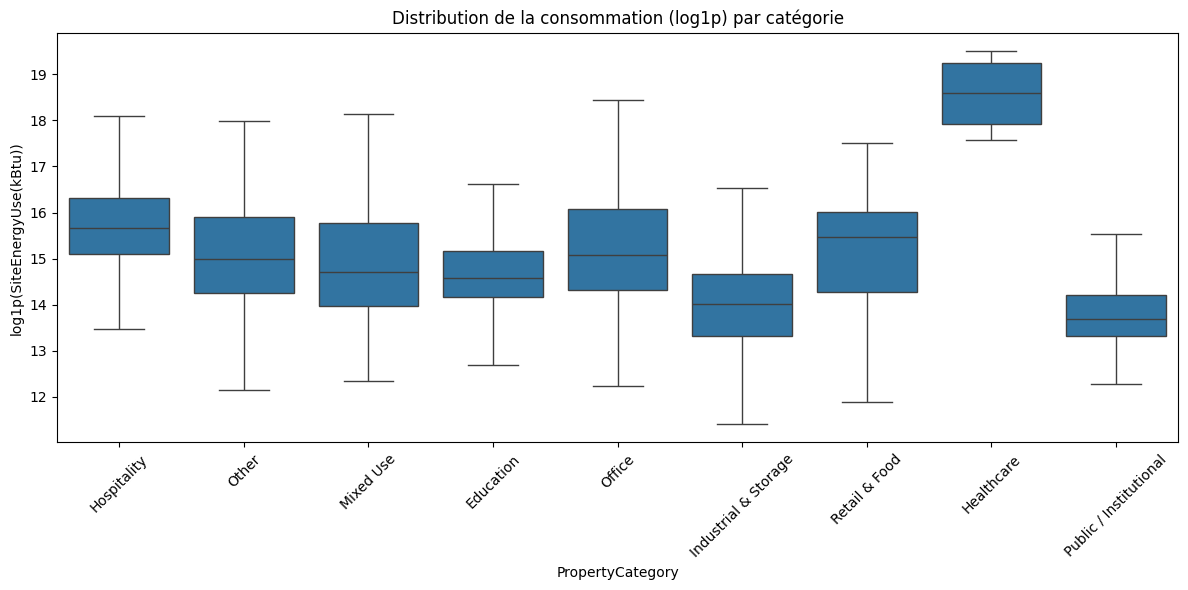

In [14]:
# Consommation par catégorie de bâtiment (variable log transformée)

log_col = "Log_SiteEnergyUse(kBtu)"
if log_col not in ml_df.columns:
    ml_df[log_col] = np.log1p(ml_df[target])  # target est défini dans une cellule précédente

plt.figure(figsize=(12,6))
sns.boxplot(x="PropertyCategory",
            y=log_col,
            data=ml_df,
            showfliers=False)
plt.title("Distribution de la consommation (log1p) par catégorie")
plt.xticks(rotation=45)
plt.ylabel("log1p(SiteEnergyUse(kBtu))")
plt.tight_layout()
plt.show()

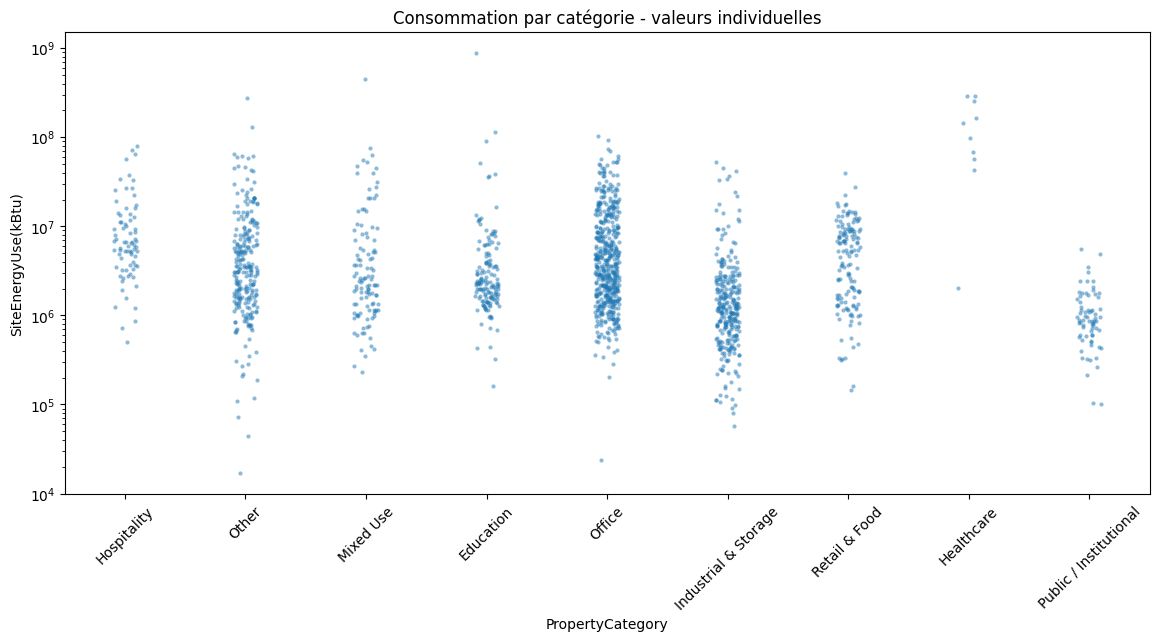

In [15]:
plt.figure(figsize=(14,6))
sns.stripplot(x="PropertyCategory", y="SiteEnergyUse(kBtu)", data=ml_df, size=3, alpha=0.5)
plt.yscale("log")
plt.title("Consommation par catégorie - valeurs individuelles")
plt.xticks(rotation=45)
plt.show()

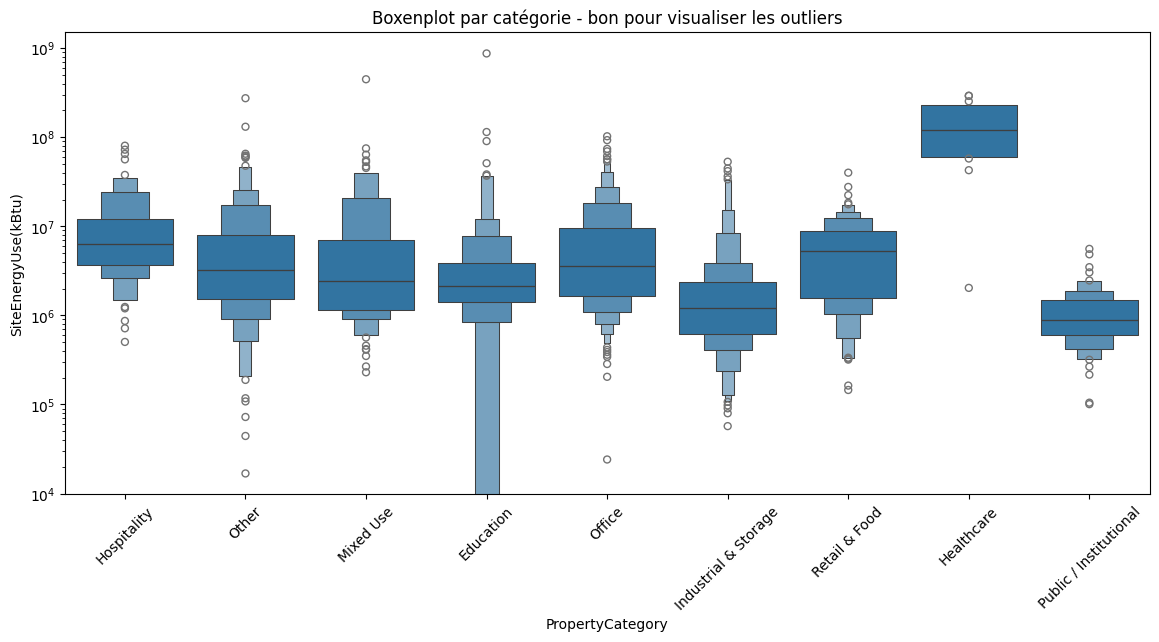

In [16]:
plt.figure(figsize=(14,6))
sns.boxenplot(x="PropertyCategory", y="SiteEnergyUse(kBtu)", data=ml_df)
plt.yscale("log")
plt.title("Boxenplot par catégorie - bon pour visualiser les outliers")
plt.xticks(rotation=45)
plt.show()

C:\Users\antoi\AppData\Local\Temp\ipykernel_23144\2465441413.py:2: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x="PropertyCategory", y="SiteEnergyUse(kBtu)", data=ml_df, scale="width", inner="quartile")


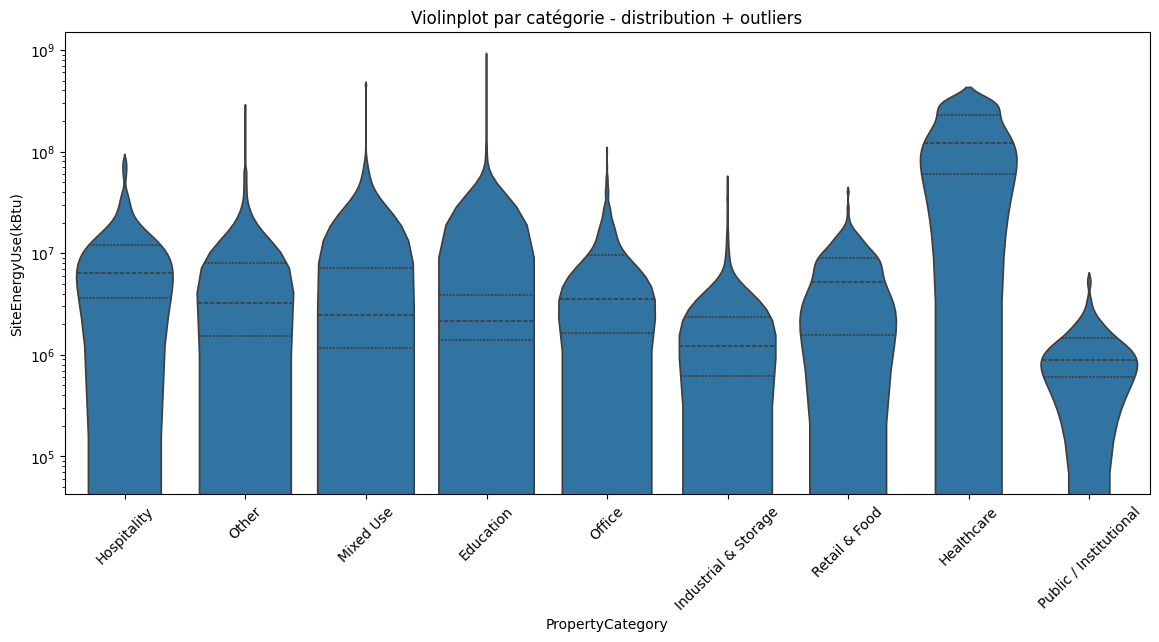

In [17]:
plt.figure(figsize=(14,6))
sns.violinplot(x="PropertyCategory", y="SiteEnergyUse(kBtu)", data=ml_df, scale="width", inner="quartile")
plt.yscale("log")
plt.title("Violinplot par catégorie - distribution + outliers")
plt.xticks(rotation=45)
plt.show()

### Suppression des outliers  
Nettoyage des valeurs aberrantes selon la méthode IQR.

### Détection des outliers IQR sur la cible SiteEnergyUse(kBtu) par PropertyCategory (ml_df_iqr) SANS disocier la CategoryProprety



In [18]:
# Détection des outliers IQR sur la cible SiteEnergyUse(kBtu) par PropertyCategory
def iqr_bounds(s, k=1.5):
    Q1, Q3 = s.quantile(0.25), s.quantile(0.75)
    IQR = Q3 - Q1
    return Q1 - k*IQR, Q3 + k*IQR

lo, hi = iqr_bounds(ml_df[target], k=1.5)
mask_out = (ml_df[target] < lo) | (ml_df[target] > hi)
target_outliers = ml_df.loc[mask_out]

print(f"Bornes IQR cible: [{lo:,.0f}, {hi:,.0f}]")
print(f"Outliers cible: {mask_out.sum()} ({mask_out.mean():.2%})")
print("Top 5 outliers (plus élevés):")
display(target_outliers.sort_values(target, ascending=False).head())

# Dataset sans outliers (si tu veux l'utiliser ensuite à la place de ml_df)
ml_df_iqr = ml_df.loc[~mask_out].reset_index(drop=True)
print("Shape sans outliers cible:", ml_df_iqr.shape)

Bornes IQR cible: [-7,249,910, 15,323,599]
Outliers cible: 182 (11.19%)
Top 5 outliers (plus élevés):


,BuildingAge,Surface moyenne par étage,Ratio Largest Use / Total,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,...,SiteEnergyUse(kBtu),PropertyCategory_Healthcare,PropertyCategory_Hospitality,PropertyCategory_Industrial & Storage,PropertyCategory_Mixed Use,PropertyCategory_Office,PropertyCategory_Other,PropertyCategory_Public / Institutional,PropertyCategory_Retail & Food,Log_SiteEnergyUse(kBtu)
1590,116,NaN,1.000000,111.0,0,9320156,0,9320156,9320156.0,0.0,...,873923712.0,0,0,0,0,0,0,0,0,20.588504
34,24,164945.000000,1.529857,1.0,3,494835,0,494835,757027.0,639931.0,...,448385312.0,0,0,0,1,0,0,0,0,19.921163
165,16,144836.375000,1.165265,9.0,8,1158691,0,1158691,1350182.0,387651.0,...,293090784.0,1,0,0,0,0,0,0,0,19.495993
603,22,126140.714286,0.928291,7.0,14,1765970,0,1765970,1639334.0,441551.0,...,291614432.0,1,0,0,0,0,0,0,0,19.490943
543,35,13012.272727,0.510001,1.0,33,429405,0,429405,218997.0,210409.0,...,274682208.0,0,0,0,0,0,1,0,0,19.431125


Shape sans outliers cible: (1445, 21)


### Détection des outliers IQR sur la cible SiteEnergyUse(kBtu) par PropertyCategory (ml_df_iqr_cat) AVEC la CategoryProprety


In [19]:
# Détection / traitement des outliers de SiteEnergyUse(kBtu) par catégorie

target = "SiteEnergyUse(kBtu)"  # déjà défini plus haut normalement
cat_col = "PropertyCategory"
k = 1.5          # facteur IQR (augmenter à 2.0 si trop de suppressions)
min_n = 8        # taille minimale pour appliquer IQR
use_log = False  # passer à True pour détecter sur log1p (souvent plus stable)
apply_capping = False  # True => on garde toutes les lignes et on cape au lieu de supprimer

def iqr_bounds(s, k=1.5):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lo = q1 - k * iqr
    hi = q3 + k * iqr
    # énergie négative impossible => tronquer à 0
    return max(0, lo), hi

if cat_col not in ml_df.columns:
    raise KeyError(f"Colonne catégorie absente: {cat_col}")

work_df = ml_df.copy()

# Colonne utilisée pour la détection
detect_col = target
if use_log:
    detect_col = "_log_target"
    work_df[detect_col] = np.log1p(work_df[target])

records = []
outlier_frames = []
clean_frames = []
capped_values = 0

for cat, sub in work_df.groupby(cat_col):
    n = len(sub)
    if n < min_n:
        # Catégorie trop petite: on ne filtre pas
        clean_frames.append(sub)
        records.append({
            "category": cat, "n": n,
            "lo": None, "hi": None,
            "removed": 0, "removed_pct": 0.0,
            "capped": 0, "note": "skip (n<min_n)"
        })
        continue

    lo, hi = iqr_bounds(sub[detect_col], k=k)

    if not use_log:
        mask_out = (sub[detect_col] < lo) | (sub[detect_col] > hi)
    else:
        # Détection sur log -> limites dans l'espace log
        mask_out = (sub[detect_col] < lo) | (sub[detect_col] > hi)

    n_out = int(mask_out.sum())

    if apply_capping and n_out > 0:
        # Winsorisation
        sub_c = sub.copy()
        before_vals = sub_c.loc[mask_out, target]
        if use_log:
            # Convertir bornes log -> échelle originale
            lo_orig = np.expm1(lo)
            hi_orig = np.expm1(hi)
            sub_c.loc[sub_c[target] < lo_orig, target] = lo_orig
            sub_c.loc[sub_c[target] > hi_orig, target] = hi_orig
        else:
            sub_c.loc[sub_c[target] < lo, target] = lo
            sub_c.loc[sub_c[target] > hi, target] = hi
        capped_values += n_out
        clean_frames.append(sub_c)
        records.append({
            "category": cat, "n": n,
            "lo": lo, "hi": hi,
            "removed": 0, "removed_pct": 0.0,
            "capped": n_out,
            "note": "capped"
        })
    else:
        # Suppression
        if n_out:
            outlier_part = sub.loc[mask_out].assign(_lo=lo, _hi=hi, _category=cat)
            outlier_frames.append(outlier_part)
        clean_frames.append(sub.loc[~mask_out])
        records.append({
            "category": cat, "n": n,
            "lo": lo, "hi": hi,
            "removed": n_out,
            "removed_pct": n_out / n if n else 0.0,
            "capped": 0,
            "note": ""
        })

outliers_cat = (pd.concat(outlier_frames, ignore_index=True)
                if outlier_frames and not apply_capping
                else pd.DataFrame(columns=[target, detect_col, "_category", "_lo", "_hi"]))

ml_df_iqr_cat = pd.concat(clean_frames, ignore_index=True)

summary_cat = (pd.DataFrame(records)
               .sort_values(["removed","capped"], ascending=False)
               .reset_index(drop=True))

print("Résumé par catégorie (top 15):")
display(summary_cat.head(15))

if not apply_capping:
    print(f"\nTotal supprimé : {len(outliers_cat)} / {len(work_df)} ({len(outliers_cat)/len(work_df):.2%})")
    print("Shape dataset nettoyé :", ml_df_iqr_cat.shape)
    if not outliers_cat.empty:
        print("\nExemples outliers (5 plus élevés):")
        display(outliers_cat.sort_values(target, ascending=False).head())
else:
    print(f"\nTotal valeurs capées : {capped_values} / {len(work_df)} ({capped_values/len(work_df):.2%})")
    print("Shape dataset (inchangé sauf valeurs capées):", ml_df_iqr_cat.shape)

# Nettoyage colonne temporaire
if use_log and detect_col in ml_df_iqr_cat.columns:
    ml_df_iqr_cat.drop(columns=[detect_col], inplace=True)


Résumé par catégorie (top 15):


,category,n,lo,hi,removed,removed_pct,capped,note
0,Office,507,0,2.127660e+07,50,0.098619,0,
1,Other,253,0,1.783597e+07,30,0.118577,0,
2,Industrial & Storage,290,0,4.939984e+06,26,0.089655,0,
3,Education,163,0,7.476770e+06,22,0.134969,0,
4,Mixed Use,114,0,1.593425e+07,16,0.140351,0,
5,Hospitality,76,0,2.485791e+07,10,0.131579,0,
6,Public / Institutional,71,0,2.785217e+06,4,0.056338,0,
7,Retail & Food,143,0,1.993269e+07,3,0.020979,0,
8,Healthcare,10,0,4.878831e+08,0,0.000000,0,



Total supprimé : 161 / 1627 (9.90%)
Shape dataset nettoyé : (1466, 21)

Exemples outliers (5 plus élevés):


,BuildingAge,Surface moyenne par étage,Ratio Largest Use / Total,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,...,PropertyCategory_Industrial & Storage,PropertyCategory_Mixed Use,PropertyCategory_Office,PropertyCategory_Other,PropertyCategory_Public / Institutional,PropertyCategory_Retail & Food,Log_SiteEnergyUse(kBtu),_lo,_hi,_category
20,116,NaN,1.000000,111.0,0,9320156,0,9320156,9320156.0,0.0,...,0,0,0,0,0,0,20.588504,0,7.476770e+06,Education
58,24,1.649450e+05,1.529857,1.0,3,494835,0,494835,757027.0,639931.0,...,0,1,0,0,0,0,19.921163,0,1.593425e+07,Mixed Use
142,35,1.301227e+04,0.510001,1.0,33,429405,0,429405,218997.0,210409.0,...,0,0,0,1,0,0,19.431125,0,1.783597e+07,Other
138,19,1.071894e+05,1.000000,1.0,5,535947,0,535947,535947.0,103983.0,...,0,0,0,1,0,0,18.693558,0,1.783597e+07,Other
15,77,1.100000e+06,0.781656,1.0,2,2200000,0,2200000,1719643.0,318960.0,...,0,0,0,0,0,0,18.557382,0,7.476770e+06,Education


In [20]:
#Enregistrement du dataset nettoyé avec la gestion des outliers IQR par catégorie (ml_df_iqr_cat Celui avec CategoryProperty)
ml_df_iqr_cat.to_csv('ML_modele_iqr_cat.csv', index=False)
print("Dataset nettoyé enregistré sous 'ML_modele_iqr_cat.csv'")

Dataset nettoyé enregistré sous 'ML_modele_iqr_cat.csv'


In [21]:
# Aperçu général de la variable cible sans nettoyage des outliers
print(ml_df[target].dtype)
print("Min réel =", ml_df[target].min())
print("Q1=", ml_df[target].quantile(0.25), "Q3=", ml_df[target].quantile(0.75))
print("Max réel =", ml_df[target].max())

float64
Min réel = 0.0
Q1= 1215156.25 Q3= 6858533.5
Max réel = 873923712.0


In [22]:
# Aperçu général de la variable cible après nettoyage des outliers ml_df_iqr
print(ml_df_iqr[target].dtype)
print("Min réel =", ml_df_iqr[target].min())
print("Q1=", ml_df_iqr[target].quantile(0.25), "Q3=", ml_df_iqr[target].quantile(0.75))
print("Max réel =", ml_df_iqr[target].max())

float64
Min réel = 0.0
Q1= 1095793.5 Q3= 4783612.75
Max réel = 15272491.0


In [23]:
# Aperçu général de la variable cible après nettoyage des outliers (par catégorie) ml_df_iqr_cat
print(ml_df_iqr_cat[target].dtype)
print("Min réel =", ml_df_iqr_cat[target].min())
print("Q1=", ml_df_iqr_cat[target].quantile(0.25), "Q3=", ml_df_iqr_cat[target].quantile(0.75))
print("Max réel =", ml_df_iqr_cat[target].max())

float64
Min réel = 0.0
Q1= 1110548.03125 Q3= 5073531.5
Max réel = 293090784.0


### Visualisation après nettoyage  
Histogramme de la cible une fois les outliers supprimés.

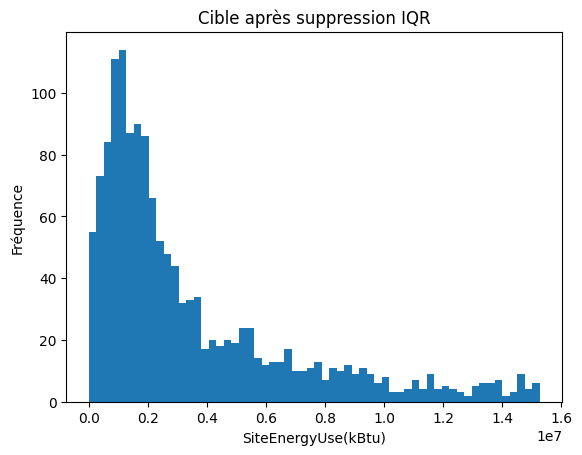

In [24]:
# Visualisation de la variable cible apres nettoyage des outliers

plt.figure()
plt.hist(ml_df_iqr[target], bins=60)
plt.title("Cible après suppression IQR")
plt.xlabel(target); plt.ylabel("Fréquence")
plt.show()  

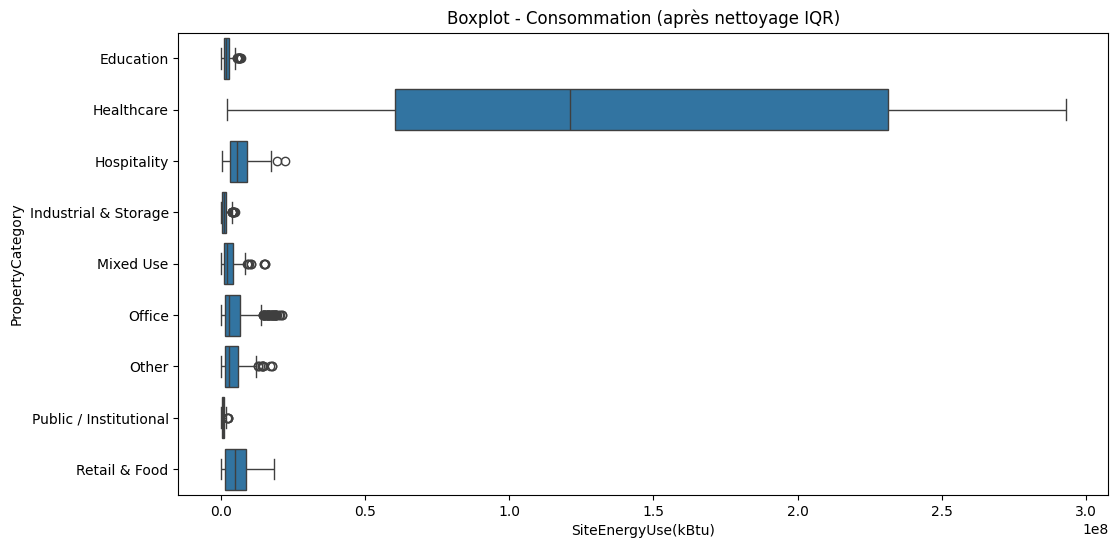

In [25]:
# Consommation par catégorie de bâtiment après nettoyage des outliers
plt.figure(figsize=(12,6))
sns.boxplot(x=ml_df_iqr_cat[target], y=ml_df_iqr_cat['PropertyCategory'])
plt.title("Boxplot - Consommation (après nettoyage IQR)")
plt.show()


C:\Users\antoi\AppData\Local\Temp\ipykernel_23144\2203716073.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


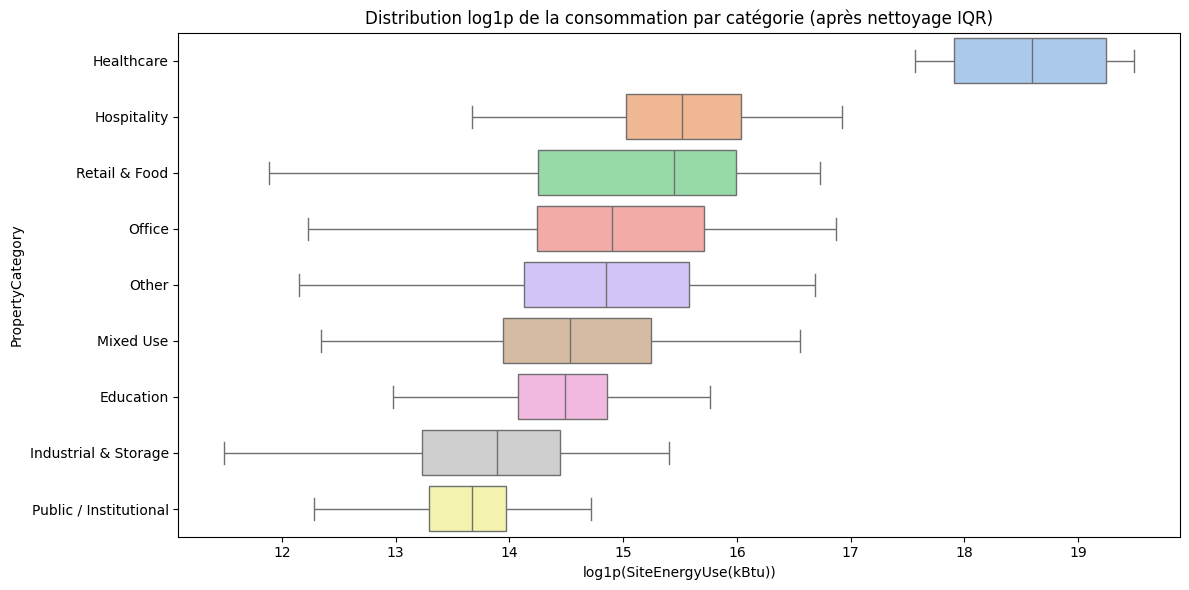

In [26]:
# Boxplot log1p de la consommation après nettoyage (par catégorie)

log_col = "log1p_" + target.replace("(", "_").replace(")", "").replace("/", "_")
if log_col not in ml_df_iqr_cat.columns:
    ml_df_iqr_cat[log_col] = np.log1p(ml_df_iqr_cat[target])

# ordre des catégories (médiane décroissante en log)
order = (ml_df_iqr_cat
         .groupby("PropertyCategory")[log_col]
         .median()
         .sort_values(ascending=False)
         .index)

plt.figure(figsize=(12,6))
sns.boxplot(
    data=ml_df_iqr_cat,
    y="PropertyCategory",
    x=log_col,
    order=order,
    showfliers=False,
    palette="pastel"
)
plt.xlabel(f"log1p({target})")
plt.ylabel("PropertyCategory")
plt.title("Distribution log1p de la consommation par catégorie (après nettoyage IQR)")
plt.tight_layout()
plt.show()

# Astuce: pour revenir à l’échelle originale sur un point: valeur = exp(log1p_val) - 1


### Vérification des corrélations  
Identification et suppression des variables redondantes à partir de la matrice de corrélation.


Text(0.5, 1.0, 'Matrice de corrélation')

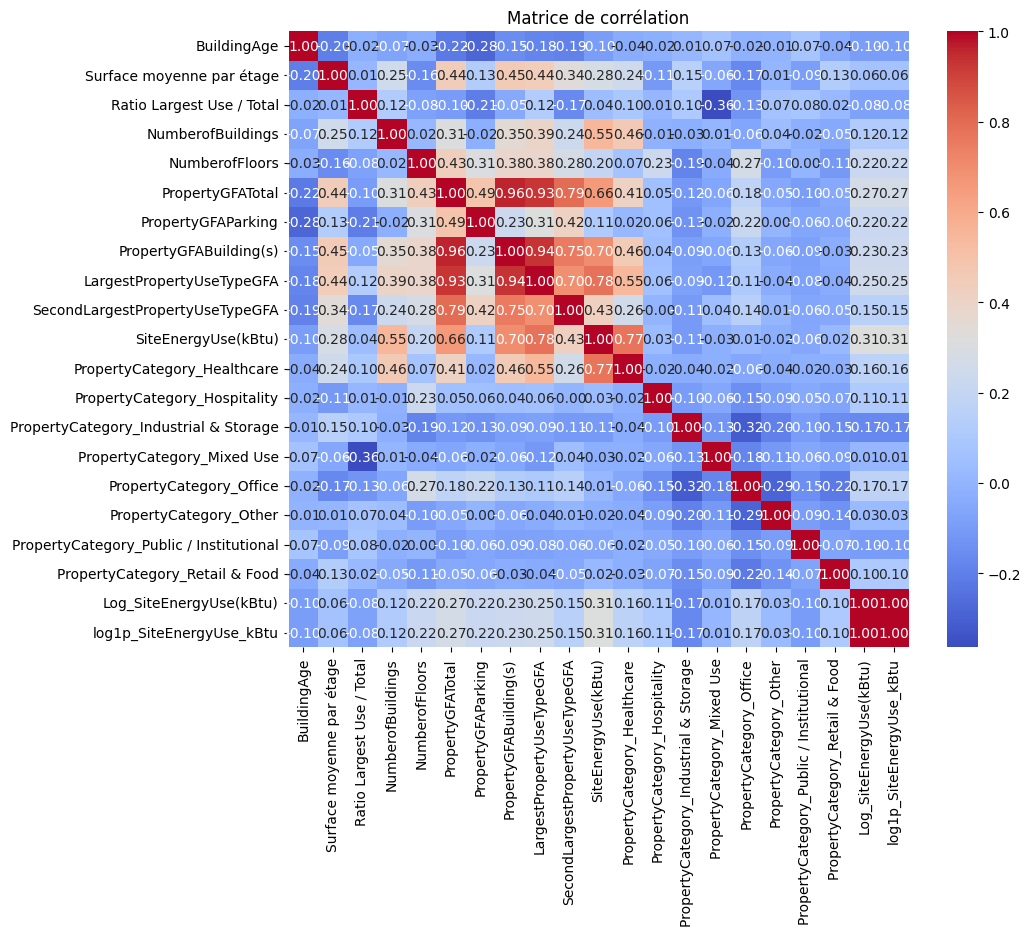

In [27]:
#identification des variables redondantes dans le dataset ml_df_iqr_cat 
corr_matrix = ml_df_iqr_cat.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matrice de corrélation")

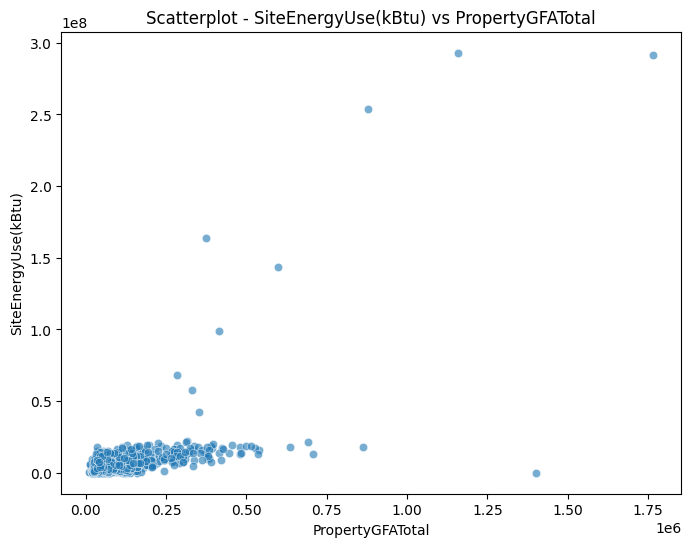

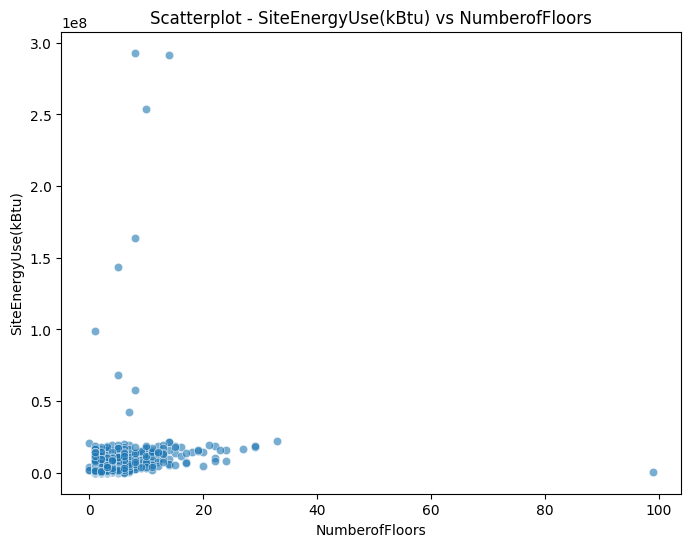

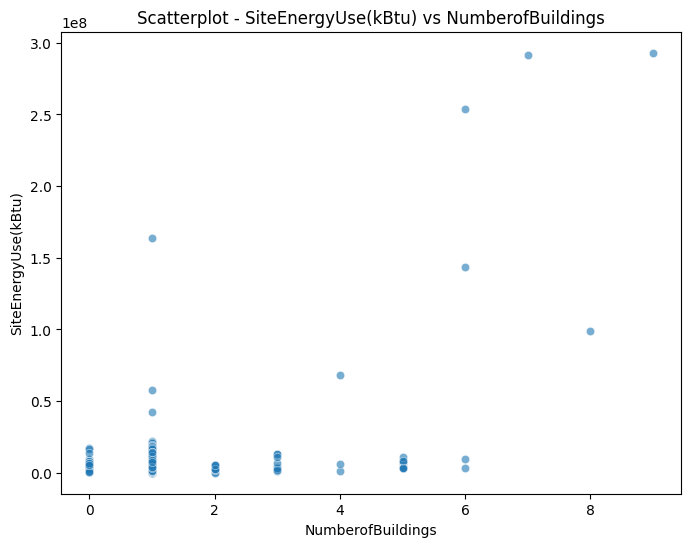

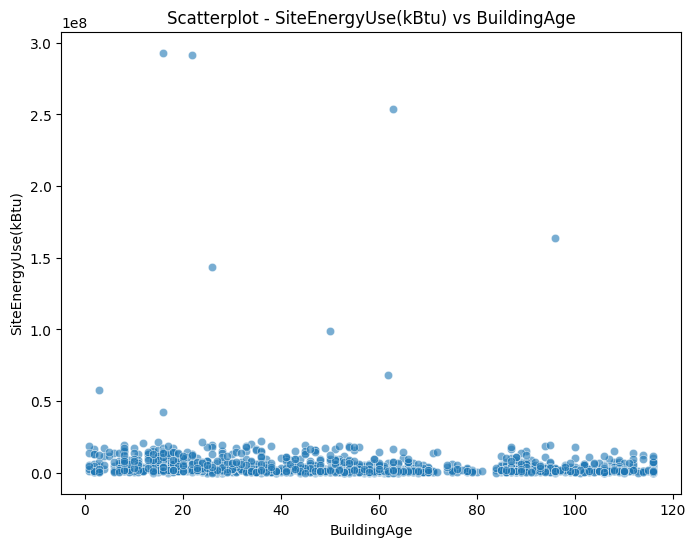

In [28]:
# Scatterplots target vs quelques features numérique ["PropertyGFATotal", "NumberofFloors", "NumberofBuildings", "BuildingAge"]
features = ['PropertyGFATotal', 'NumberofFloors', 'NumberofBuildings', 'BuildingAge']
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=ml_df_iqr_cat, x=feature, y=target, alpha=0.6)
    plt.title(f"Scatterplot - {target} vs {feature}")
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.show()


In [29]:
display(ml_df_iqr_cat.head())

,BuildingAge,Surface moyenne par étage,Ratio Largest Use / Total,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,...,PropertyCategory_Healthcare,PropertyCategory_Hospitality,PropertyCategory_Industrial & Storage,PropertyCategory_Mixed Use,PropertyCategory_Office,PropertyCategory_Other,PropertyCategory_Public / Institutional,PropertyCategory_Retail & Food,Log_SiteEnergyUse(kBtu),log1p_SiteEnergyUse_kBtu
0,55,28114.0,1.047805,1.0,2,56228,0,56228,58916.0,0.0,...,0,0,0,0,0,0,0,0,14.246955,14.246955
1,61,126351.0,1.000000,1.0,1,126351,0,126351,126351.0,0.0,...,0,0,0,0,0,0,0,0,0.000000,0.000000
2,67,80322.5,1.022310,1.0,2,160645,0,160645,164229.0,0.0,...,0,0,0,0,0,0,0,0,15.729366,15.729366
3,27,25791.0,1.069482,1.0,2,51582,0,51582,55166.0,0.0,...,0,0,0,0,0,0,0,0,0.000000,0.000000
4,26,27493.0,1.000000,1.0,2,54986,0,54986,54986.0,0.0,...,0,0,0,0,0,0,0,0,14.316456,14.316456


# Séparation Train/Test + Validation croisée

In [30]:
#Séparation des features et de la target

#Colonne cible
log_col = "log1p_SiteEnergyUse_kBtu"

#  Listes des features numériques et catégorielles en dummy
numeric_feats = [
    "BuildingAge",
    "Surface moyenne par étage",
    "Ratio Largest Use / Total",
    "NumberofBuildings",
    "NumberofFloors",
    "PropertyGFATotal",
    "PropertyGFAParking",
    "PropertyGFABuilding(s)",
    "LargestPropertyUseTypeGFA",
    "SecondLargestPropertyUseTypeGFA",
]

dummy_feats = [
    "PropertyCategory_Healthcare",
    "PropertyCategory_Hospitality",
    "PropertyCategory_Industrial & Storage",
    "PropertyCategory_Mixed Use",
    "PropertyCategory_Office",
    "PropertyCategory_Other",
    "PropertyCategory_Public / Institutional",
    "PropertyCategory_Retail & Food",
]

all_feats = numeric_feats + dummy_feats

X = ml_df_iqr_cat[all_feats]
y = ml_df_iqr_cat[log_col]  # Utilisation de la cible log



In [31]:
#  Dataset final
X = ml_df_iqr_cat[all_feats].copy()
y = ml_df_iqr_cat[log_col].copy()


In [32]:
#  Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Shapes -> X_train:", X_train.shape, "X_test:", X_test.shape)

Shapes -> X_train: (1172, 18) X_test: (294, 18)


In [33]:
# Vérifier la taille de X_train, X_test, y_train, y_test.
print("Taille de X_train:", X_train.shape)
print("Taille de X_test:", X_test.shape)
print("Taille de y_train:", y_train.shape)
print("Taille de y_test:", y_test.shape)

Taille de X_train: (1172, 18)
Taille de X_test: (294, 18)
Taille de y_train: (1172,)
Taille de y_test: (294,)


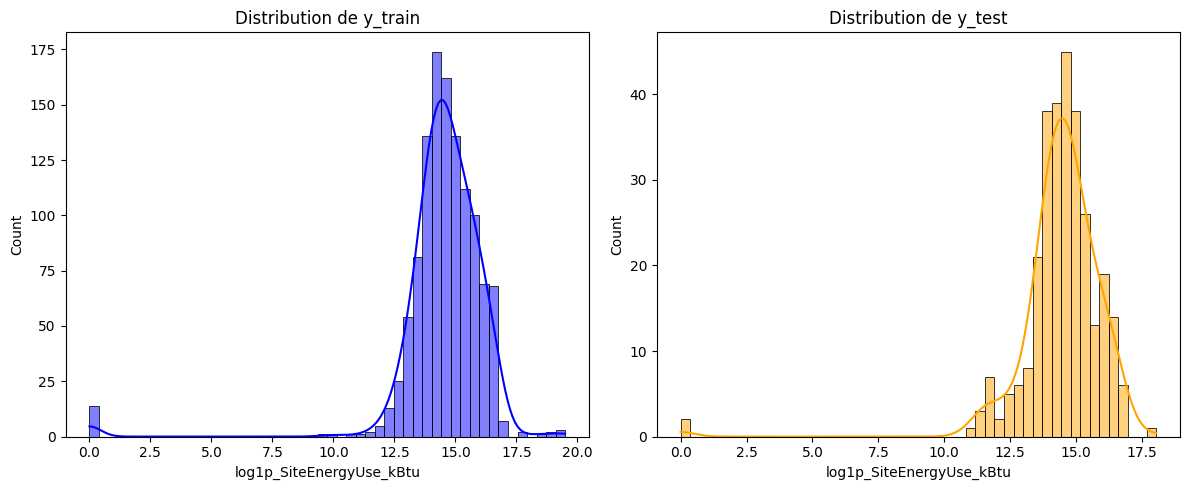

In [34]:
# Vérification de la distribution de y entre train et test → éviter un dataset déséquilibré.

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(y_train, bins=50, kde=True, color='blue')
plt.title("Distribution de y_train")

plt.subplot(1,2,2)
sns.histplot(y_test, bins=50, kde=True, color='orange')
plt.title("Distribution de y_test")

plt.tight_layout()
plt.show()

In [35]:
# préprocesseur scaler seulement pour les features numériques
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_feats)
    ],
    remainder='passthrough'  # les autres colonnes (dummy) restent inchangées
)

In [36]:
#Vérification des données prêtes pour la modélisation

ml_df_raw    = pd.read_csv("ML_modele.csv")
ml_df_iqr_cat = pd.read_csv("ML_modele_iqr_cat.csv")  # <-- dataset pour la modélisation


In [37]:
# Créer la cible log1p si elle n'existe pas
if "log1p_SiteEnergyUse_kBtu" not in ml_df_iqr_cat.columns:
    ml_df_iqr_cat["log1p_SiteEnergyUse_kBtu"] = np.log1p(ml_df_iqr_cat["SiteEnergyUse(kBtu)"].astype(float))

#  Supprimer l'autre version pour éviter toute confusion
if "Log_SiteEnergyUse(kBtu)" in ml_df_iqr_cat.columns:
    ml_df_iqr_cat = ml_df_iqr_cat.drop(columns=["Log_SiteEnergyUse(kBtu)"])

#  Définir la target à utiliser partout
log_col = "log1p_SiteEnergyUse_kBtu"

#  Définir tes features (adaptées à ton CSV)
all_feats = [
    "BuildingAge",
    "Surface moyenne par étage",
    "Ratio Largest Use / Total",
    "NumberofBuildings",
    "NumberofFloors",
    "PropertyGFATotal",
    "PropertyGFAParking",
    "PropertyGFABuilding(s)",
    "LargestPropertyUseTypeGFA",
    "SecondLargestPropertyUseTypeGFA",
    # dummies de catégories :
    "PropertyCategory_Healthcare",
    "PropertyCategory_Hospitality",
    "PropertyCategory_Industrial & Storage",
    "PropertyCategory_Mixed Use",
    "PropertyCategory_Office",
    "PropertyCategory_Other",
    "PropertyCategory_Public / Institutional",
    "PropertyCategory_Retail & Food",
]

# Sanity check colonnes
missing = [c for c in all_feats + [log_col] if c not in ml_df_iqr_cat.columns]
assert not missing, f"Colonnes introuvables dans ml_df_iqr_cat : {missing}"

# X / y finaux
X = ml_df_iqr_cat[all_feats].copy()
y = ml_df_iqr_cat[log_col].astype(float).copy()

print("X:", X.shape, "| y:", y.shape)


X: (1466, 18) | y: (1466,)


In [38]:
# Vérifier NaN / inf dans la cible (et features)
print("NaN y:", y.isna().sum(), "| NaN X:", X.isna().sum().sum())

# Si besoin, remplacer +/-inf résiduels (devraient être inexistants avec log1p)
y = y.replace([np.inf, -np.inf], np.nan)


NaN y: 2 | NaN X: 16


In [39]:
# Nettoyage final avant modélisation : suppression des NaN dans X et y

# 1. Supprimer les lignes où y est NaN
mask = y.notna()
X = X[mask]
y = y[mask]

# 2. Supprimer les lignes où X contient des NaN
nan_mask = ~X.isna().any(axis=1)
X = X[nan_mask]
y = y[nan_mask]

print("Après suppression NaN -> X:", X.shape, "| y:", y.shape)
# Vérifier NaN / inf dans la cible (et features) après nettoyage
print("NaN y:", y.isna().sum(), "| NaN X:", X.isna().sum().sum())
print("Inf y:", np.isinf(y).sum(), "| Inf X:", np.isinf(X).sum().sum())

Après suppression NaN -> X: (1457, 18) | y: (1457,)
NaN y: 0 | NaN X: 0
Inf y: 0 | Inf X: 0


Shapes -> X_train: (1165, 18) | X_test: (292, 18) | y_train: (1165,) | y_test: (292,)


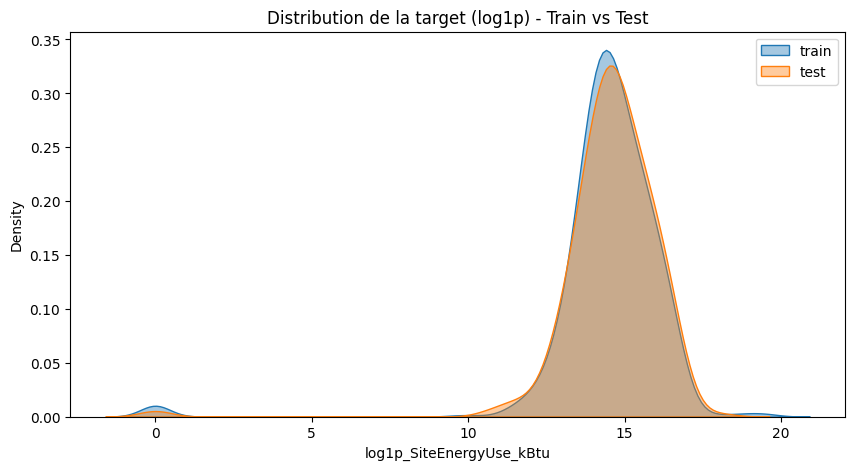

In [40]:
# Split final
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Shapes ->",
      "X_train:", X_train.shape, "| X_test:", X_test.shape,
      "| y_train:", y_train.shape, "| y_test:", y_test.shape)

# contrôle visuel
plt.figure(figsize=(10,5))
sns.kdeplot(y_train, label="train", fill=True, alpha=0.4)
sns.kdeplot(y_test,  label="test",  fill=True, alpha=0.4)
plt.title("Distribution de la target (log1p) - Train vs Test")
plt.legend(); plt.show()


### Comparaison de différents modèles supervisés

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

pipe_lin = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

pipe_rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestRegressor(random_state=42))
])

pipe_gb = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", GradientBoostingRegressor(random_state=42))
])

models = {
    "LinearRegression": pipe_lin,
    "RandomForest": pipe_rf,
    "GradientBoosting": pipe_gb
}


In [42]:
from sklearn.model_selection import cross_validate
# Évaluation des modèles avec cross-validation
# Utilisation de MAE, RMSE et R² comme métriques
scoring = {
    "MAE": "neg_mean_absolute_error",
    "RMSE": "neg_root_mean_squared_error",
    "R2": "r2",
}

cv_rows = []
for name, pipe in models.items():
    cv = cross_validate(pipe, X_train, y_train,
                        scoring=scoring, cv=5, n_jobs=-1, return_train_score=True)
    cv_rows.append({
        "model": name,
        "train_MAE": -cv["train_MAE"].mean(),
        "train_RMSE": -cv["train_RMSE"].mean(),
        "train_R2": cv["train_R2"].mean(),
        "test_MAE": -cv["test_MAE"].mean(),
        "test_RMSE": -cv["test_RMSE"].mean(),
        "test_R2": cv["test_R2"].mean(),
        "test_RMSE_std": cv["test_RMSE"].std()
    })

cv_df = pd.DataFrame(cv_rows).sort_values("test_RMSE")
display(cv_df)

best_name = cv_df.iloc[0]["model"]
print(" Meilleur modèle (CV):", best_name)


,model,train_MAE,train_RMSE,train_R2,test_MAE,test_RMSE,test_R2,test_RMSE_std
1,RandomForest,0.304715,0.703494,0.869988,0.801990,1.781183,0.136416,0.338723
0,LinearRegression,0.901230,1.716586,0.225222,0.928800,1.794859,0.133508,0.352930
2,GradientBoosting,0.522842,0.927175,0.773274,0.802807,1.852725,0.066075,0.354403


 Meilleur modèle (CV): RandomForest


### Fit final + métriques (log-scale) + (option) métriques remises à l’échelle kBtu

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

best_pipe = models[best_name].fit(X_train, y_train)

y_pred_train = best_pipe.predict(X_train)
y_pred_test  = best_pipe.predict(X_test)

def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)   # <-- sans 'squared'
    rmse = np.sqrt(mse)                        # <-- on prend la racine
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

mae_tr, rmse_tr, r2_tr = metrics(y_train, y_pred_train)
mae_te, rmse_te, r2_te = metrics(y_test,  y_pred_test)

print("=== Scores (target log1p) ===")
print(f"Train -> MAE:{mae_tr:.4f} | RMSE:{rmse_tr:.4f} | R2:{r2_tr:.4f}")
print(f"Test  -> MAE:{mae_te:.4f} | RMSE:{rmse_te:.4f} | R2:{r2_te:.4f}")

# back-transform (kBtu)
y_test_kbtu = np.expm1(y_test)
y_pred_kbtu = np.expm1(y_pred_test)
mae_k = mean_absolute_error(y_test_kbtu, y_pred_kbtu)
rmse_k = np.sqrt(mean_squared_error(y_test_kbtu, y_pred_kbtu))
print("\n≈ Scores kBtu (expm1) — à interpréter avec prudence")
print(f"Test -> MAE_kBtu:{mae_k:,.0f} | RMSE_kBtu:{rmse_k:,.0f}")



=== Scores (target log1p) ===
Train -> MAE:0.3034 | RMSE:0.6758 | R2:0.8802
Test  -> MAE:0.7395 | RMSE:1.5317 | R2:0.1449

≈ Scores kBtu (expm1) — à interpréter avec prudence
Test -> MAE_kBtu:1,826,507 | RMSE_kBtu:3,055,634


### Importances des features

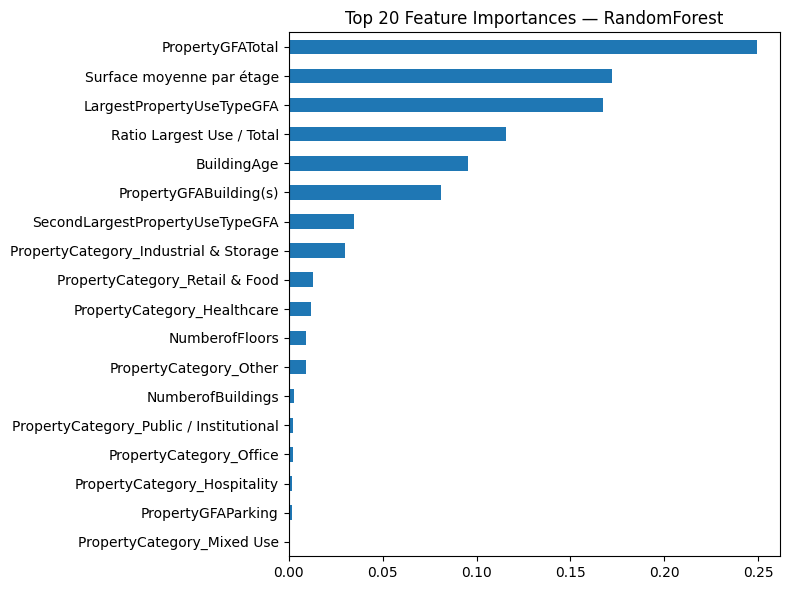

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

if best_name in ["RandomForest", "GradientBoosting"]:
    fitted = best_pipe.named_steps["model"]
    if hasattr(fitted, "feature_importances_"):
        importances = pd.Series(fitted.feature_importances_, index=X.columns)
        topk = importances.sort_values(ascending=False).head(20)
        plt.figure(figsize=(8,6))
        topk.sort_values().plot(kind="barh")
        plt.title(f"Top 20 Feature Importances — {best_name}")
        plt.tight_layout(); plt.show()
    else:
        print("Pas de feature_importances_.")
else:
    print("Modèle linéaire : utiliser coefficients ou permutation importance.")


### GridSearchCV (sur le meilleur modèle d’arbres ou forcer)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
=== GridSearch terminé ===
Best params: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 300}
Best CV MSE: 3.063950 | Best CV RMSE: 1.750414

Scores TEST après tuning (log1p):
MAE:0.7098 | RMSE:1.4609 | R2:0.2221


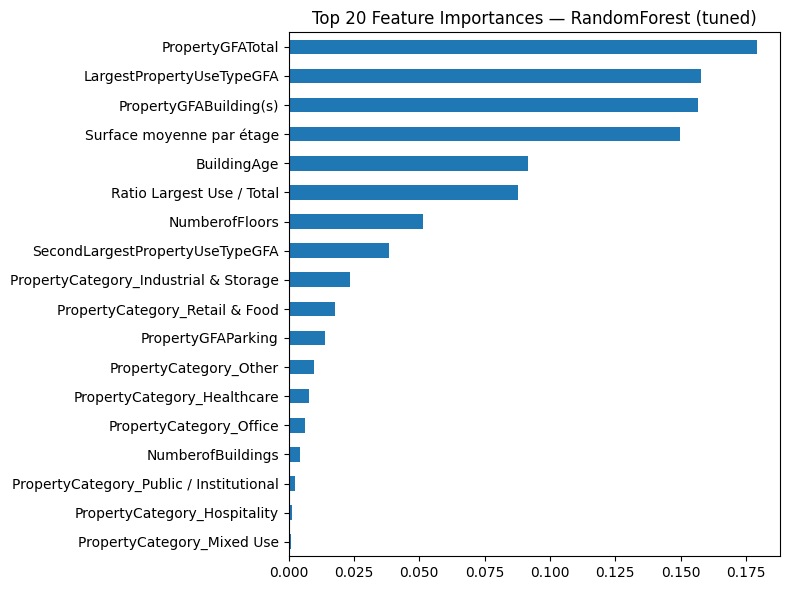

In [45]:
# === GridSearchCV (compatible sklearn ancien) ===
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

model_to_tune = best_name  # ou "RandomForest" / "GradientBoosting"

if model_to_tune == "RandomForest":
    base_pipe = pipe_rf
    param_grid = {
        "model__n_estimators": [300, 600],
        "model__max_depth": [None, 20, 40],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4],
        "model__max_features": ["sqrt", "log2", None]
    }
elif model_to_tune == "GradientBoosting":
    base_pipe = pipe_gb
    param_grid = {
        "model__n_estimators": [300, 600],
        "model__learning_rate": [0.05, 0.1],
        "model__max_depth": [2, 3, 4],
        "model__subsample": [1.0, 0.8],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4]
    }
else:
    raise ValueError("GridSearch prévu pour RF/GB.")

# ⚠️ Compatibilité: on utilise 'neg_mean_squared_error' (MSE) et on prendra la racine pour afficher le RMSE
grid = GridSearchCV(
    estimator=base_pipe,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # <-- compat
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

best_mse_cv = -grid.best_score_
best_rmse_cv = np.sqrt(best_mse_cv)

print("=== GridSearch terminé ===")
print("Best params:", grid.best_params_)
print(f"Best CV MSE: {best_mse_cv:.6f} | Best CV RMSE: {best_rmse_cv:.6f}")

best_pipe_tuned = grid.best_estimator_
y_pred_test_tuned = best_pipe_tuned.predict(X_test)

mae_t  = mean_absolute_error(y_test, y_pred_test_tuned)
mse_t  = mean_squared_error(y_test, y_pred_test_tuned)   # pas d'arg 'squared'
rmse_t = np.sqrt(mse_t)
r2_t   = r2_score(y_test, y_pred_test_tuned)

print("\nScores TEST après tuning (log1p):")
print(f"MAE:{mae_t:.4f} | RMSE:{rmse_t:.4f} | R2:{r2_t:.4f}")

# Importances du modèle tuné si arbres
if model_to_tune in ["RandomForest", "GradientBoosting"]:
    tuned_model = best_pipe_tuned.named_steps["model"]
    if hasattr(tuned_model, "feature_importances_"):
        importances = pd.Series(tuned_model.feature_importances_, index=X.columns)
        topk = importances.sort_values(ascending=False).head(20)
        plt.figure(figsize=(8,6))
        topk.sort_values().plot(kind="barh")
        plt.title(f"Top 20 Feature Importances — {model_to_tune} (tuned)")
        plt.tight_layout(); plt.show()



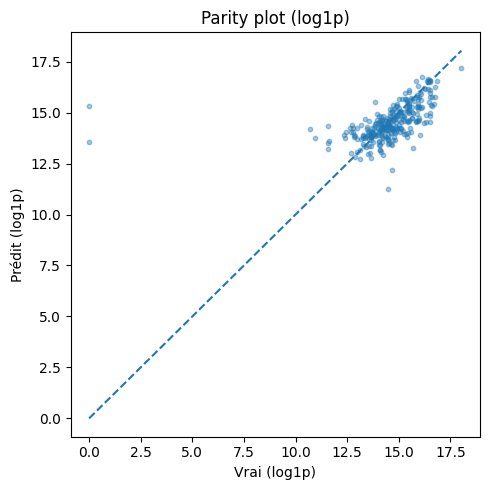

In [46]:
#  Parity plot (log1p)
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred_test_tuned, s=10, alpha=0.4)
lims = [min(y_test.min(), y_pred_test_tuned.min()), max(y_test.max(), y_pred_test_tuned.max())]
plt.plot(lims, lims, '--')
plt.xlabel("Vrai (log1p)"); plt.ylabel("Prédit (log1p)")
plt.title("Parity plot (log1p)")
plt.tight_layout(); plt.show()


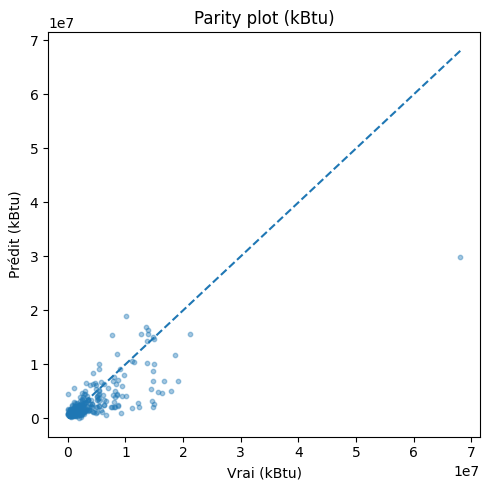

In [47]:
#  Parity plot (kBtu)
y_test_kbtu = np.expm1(y_test)
y_pred_kbtu_tuned = np.expm1(y_pred_test_tuned)

plt.figure(figsize=(5,5))
plt.scatter(y_test_kbtu, y_pred_kbtu_tuned, s=10, alpha=0.4)
lims = [min(y_test_kbtu.min(), y_pred_kbtu_tuned.min()), max(y_test_kbtu.max(), y_pred_kbtu_tuned.max())]
plt.plot(lims, lims, '--')
plt.xlabel("Vrai (kBtu)"); plt.ylabel("Prédit (kBtu)")
plt.title("Parity plot (kBtu)")
plt.tight_layout(); plt.show()


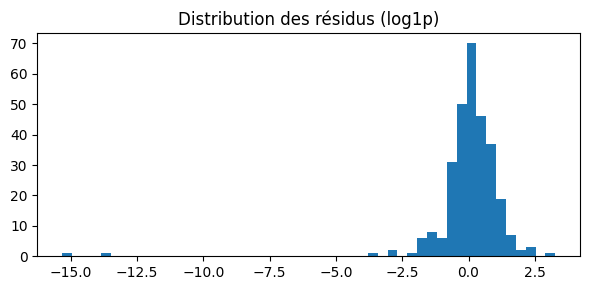

In [48]:
#  Distribution des résidus (log1p)
res_log = y_test - y_pred_test_tuned
plt.figure(figsize=(6,3))
plt.hist(res_log, bins=50)
plt.title("Distribution des résidus (log1p)")
plt.tight_layout(); plt.show()


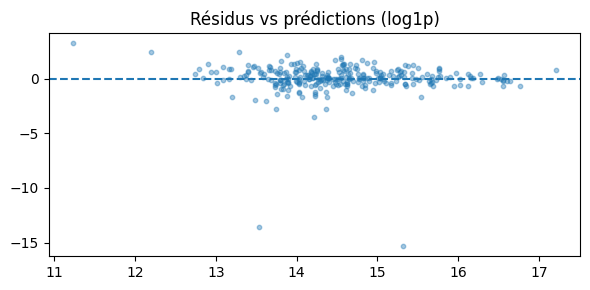

In [49]:
# Résidus vs prédictions
plt.figure(figsize=(6,3))
plt.scatter(y_pred_test_tuned, res_log, s=10, alpha=0.4)
plt.axhline(0, ls='--')
plt.title("Résidus vs prédictions (log1p)")
plt.tight_layout(); plt.show()



In [50]:
#  Erreur moyenne absolue par catégorie (si dispo)
if "PropertyCategory" in ml_df_iqr_cat.columns:
    tmp = ml_df_iqr_cat.loc[y_test.index, ["PropertyCategory"]].copy()
    tmp["abs_err_kBtu"] = np.abs(y_test_kbtu - y_pred_kbtu_tuned)
    print("\nErreur absolue moyenne (kBtu) par catégorie :")
    print(tmp.groupby("PropertyCategory")["abs_err_kBtu"].mean().sort_values(ascending=False).head(10))



Erreur absolue moyenne (kBtu) par catégorie :
PropertyCategory
Healthcare                3.825087e+07
Retail & Food             2.872890e+06
Other                     2.446823e+06
Mixed Use                 2.427307e+06
Office                    2.321598e+06
Education                 1.319535e+06
Hospitality               1.271608e+06
Industrial & Storage      7.622238e+05
Public / Institutional    2.893721e+05
Name: abs_err_kBtu, dtype: float64


In [51]:
# MAPE (si pas de zéro dans la cible)
mask_pos = y_test_kbtu > 0
mape = (np.abs(y_test_kbtu[mask_pos] - y_pred_kbtu_tuned[mask_pos]) / y_test_kbtu[mask_pos]).mean() * 100
print(f"\nMAPE (kBtu, >0) : {mape:.2f}%")


MAPE (kBtu, >0) : 82.07%


## Conclusion – Modélisation supervisée

Après avoir testé plusieurs modèles, voici les résultats principaux :

- **Régression Linéaire**  
  - Test → MAE: **0.92**, RMSE: **1.79**, R²: **0.13**  
  - Faible pouvoir prédictif, modèle trop simple.

- **Random Forest (par défaut)**  
  - Train → R²: **0.87**  
  - Test → MAE: **0.80**, RMSE: **1.78**, R²: **0.13**  
  - Bon score sur train mais faible généralisation → overfitting.

- **Gradient Boosting**  
  - Test → MAE: **0.80**, RMSE: **1.85**, R²: **0.07**  
  - Moins performant que la forêt aléatoire.

- **Random Forest optimisée (GridSearch)**  
  - Paramètres retenus : `n_estimators=300`, `max_features='sqrt'`, `min_samples_leaf=2`, `min_samples_split=2`  
  - Test → MAE: **0.71**, RMSE: **1.46**, R²: **0.22**  
  - En valeurs réelles : MAE ≈ **1,8 M kBtu**, RMSE ≈ **3 M kBtu**.  
  - Amélioration nette par rapport aux autres modèles.



###  Bilan
- La **régression linéaire** est insuffisante.  
- Le **Gradient Boosting** n’apporte pas de gain.  
- La **Random Forest optimisée** est **le meilleur modèle** : elle réduit les erreurs et améliore la capacité explicative.  

 **Modèle retenu : Random Forest optimisée**  
Elle servira de base pour la mise en production (API).

### Geler le schéma d’entrée (pour l’API)

In [52]:
# Désinstaller les versions conflictuelles
!pip uninstall -y bentoml pydantic pydantic-core _bentoml_sdk

# Réinstaller une paire compatible (testée)
!pip install "pydantic==2.7.4" "bentoml==1.3.21"


ERROR: Invalid requirement: '_bentoml_sdk': Expected package name at the start of dependency specifier
    _bentoml_sdk
    ^


  Using cached bentoml-1.3.21-py3-none-any.whl.metadata (16 kB)
Using cached bentoml-1.3.21-py3-none-any.whl (1.1 MB)
  Attempting uninstall: bentoml
    Found existing installation: bentoml 1.2.15
    Uninstalling bentoml-1.2.15:
      Successfully uninstalled bentoml-1.2.15


In [53]:
import bentoml, pydantic, sys
print("Python  :", sys.version)
print("BentoML :", bentoml.__version__)
print("Pydantic:", pydantic.__version__)


Python  : 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
BentoML : 1.3.21
Pydantic: 2.7.4


In [63]:
import bentoml
feature_names = X_train.columns.tolist()

bentoml.picklable_model.save_model(
    "energy_model",
    best_pipe_tuned,  # <— ton pipeline optimisé dans ton notebook
    custom_objects={"feature_names": feature_names},
    metadata={"framework": "scikit-learn", "type": "Pipeline optimisé (GridSearchCV)"}
)

print(bentoml.models.get("energy_model:latest"))


Model(tag="energy_model:mzpzxfu5kg5khl7m")


In [64]:
import bentoml
bentoml.models.get("energy_model")


Model(tag="energy_model:mzpzxfu5kg5khl7m", path="C:\Users\antoi\bentoml\models\energy_model\mzpzxfu5kg5khl7m")